In [1]:
from ssm import SSM
import torch
import torch.nn.functional as F
import numpy as np

In [2]:
space = SSM()

In [3]:
h_t = torch.randn((2, 512, 64), device="cuda", dtype=torch.float32)
A_bar = torch.randn((2, 512, 64, 2), device="cuda", dtype=torch.float32)
B_bar_x = torch.randn_like(A_bar)
C = torch.randn((2, 64, 2), device="cuda", dtype=torch.float32)

In [36]:
print(h_t.shape,A_bar.shape,B_bar_x.shape,C.shape)

torch.Size([2, 512, 64]) torch.Size([2, 512, 64, 2]) torch.Size([2, 512, 64, 2]) torch.Size([2, 64, 2])


In [4]:
a,b ,c = space.random_SSM(2)

In [37]:
print(a.shape,b.shape,c.shape)

torch.Size([2, 2]) torch.Size([2, 1]) torch.Size([1, 2])


In [8]:
space.discretize(a,b,c,1)

(tensor([[3.1297, 1.9813],
         [1.9116, 2.6228]]),
 tensor([[1.8986],
         [1.6967]]),
 tensor([[0.5462, 0.3724]]))

In [9]:
space.discretize_zoh(a,b,1)

(tensor([[2.0200, 2.0326],
         [1.9824, 1.6847]]),
 tensor([[2.2403],
         [0.1713]]))

In [10]:
u = torch.ones([3])
u.shape

torch.Size([3])

In [10]:
def complex_log(float_input, eps=1e-6):
        eps = float_input.new_tensor(eps)
        real = float_input.abs().maximum(eps).log()
        imag = (float_input < 0).to(float_input.dtype) * torch.pi
        return torch.complex(real, imag)

###  TODO READ THE S4 code the issue is on the input dimensionality, seems that einsum might be the answer to this issue

# Structure and Dimensions.
Finally, we note that structured SSMs are so named because computing them efficiently also requires imposing structure on the A matrix. The most popular form of structure is diagonal which we also use.

In this case, the A ∈ ℝN×N, B ∈ ℝN×1, C ∈ ℝ1×N matrices can all be represented by N numbers. 

To operate over an input sequence x of batch size B and length L with D channels, the SSM is applied independently to each
channel.

Note that in this case, the total hidden state has dimension DN per input, and computing it over the
sequence length requires O(BLDN) time and memory; this is the root of the fundamental efficiency bottleneck



# dimesnions 
 - Input(x) and output(y) are of size BLD
 - A : (DN)
 - B : (BLN) 
 - C : (BLN)
 - Delta : (BLD)
 - A_BAR, B_BAR : (BLDN) discretize with (Delta,AB)
 

In [33]:
def parallel_scan( h_t: torch.Tensor ,A_bar : torch.Tensor, B_bar: torch.Tensor, C: torch.Tensor):
        ## SSM COMPATIBLE
        # h_t = A_bar * h_t-1 + B_bar*x_t
        #y_t =C*h_t

        ## heinsen
        # x_t = a_t*x_t-1 + b_t

        # equivalent notation

        # h_t = A_bar_t * h_t-1 + B_bar*x_t
        # where x_t is the input sequence hence:
        # cat(B_bar,  x_t) = b_t' or b_t prime.
        # finally:
        # h_t = A_bar_t * h_t-1 + b_t'
        """
        In summary we need to calculate a state space equation (S4) using the heinsen method.

        """
        #b_t_prime =  torch.cat([h_t[..., None], B_bar], dim=-1)
        #b_t_prime = torch.matmul(B_bar,h_t)
        #b_t_prime = B_bar @ h_t
        b_t_prime = torch.einsum("bld,bln->bldn", h_t,B_bar)
        log_b_t = complex_log(b_t_prime)
        log_a_t = complex_log(A_bar)
        a_star = F.pad(torch.cumsum(log_a_t, dim = -1),(1,0))
        #a_star = torch.cumsum(log_a_t, dim = -1)
        print(log_b_t.shape)
        print(a_star.shape)
        log_h0_plus_b_star = torch.logcumsumexp(log_b_t - a_star, dim = -1)

        log_h = (a_star + log_h0_plus_b_star)[...,1:]
        
        h = torch.exp(log_h).real
        print(h.shape)
        y_t = torch.matmul(C, h).squeeze(-1)
        #y_t = torch.einsum("bnt,bdnt->bdt", C, h) 
        return h, y_t

In [13]:
def selective_scan(u, dt, A, B, C):
        dA = torch.einsum('bld,dn->bldn', dt, A)
        dB_u = torch.einsum('bld,bld,bln->bldn', dt, u, B)
        
        dA_cumsum = F.pad(dA[:, 1:], (0, 0, 0, 0, 0, 1)).flip(1).cumsum(1).exp().flip(1)
        x = dB_u * dA_cumsum
        x = x.cumsum(1) / (dA_cumsum + 1e-12)
        y = torch.einsum('bldn,bln->bld', x, C)
    
        return y + u

In [14]:
def compute_in_parallel(coeffs, values):
    log_coeffs = complex_log(coeffs)
    log_values = complex_log(values)
    a_star = F.pad(torch.cumsum(log_coeffs, dim=-1), (1, 0))              # eq (2) in paper
    print(log_values.shape)
    print(a_star.shape)
    log_x0_plus_b_star = torch.logcumsumexp(log_values - a_star, dim=-1)  # eq (7) in paper
    log_x = a_star + log_x0_plus_b_star                                   # eq (1) in paper
    return torch.exp(log_x).real

In [15]:
u = torch.Tensor([[1,1]])

In [16]:
u.shape

torch.Size([1, 2])

In [17]:
b.shape

torch.Size([2, 1])

In [35]:
print(a.shape,b.shape,c.shape,u.shape)

torch.Size([2, 2]) torch.Size([2, 1]) torch.Size([1, 2]) torch.Size([1, 2])


In [34]:
parallel_scan(u,a,b,c)

RuntimeError: einsum(): the number of subscripts in the equation (3) does not match the number of dimensions (2) for operand 0 and no ellipsis was given

In [20]:
compute_in_parallel(a,b)

torch.Size([2, 1])
torch.Size([2, 3])


tensor([[0.6294, 1.0719, 1.3897],
        [0.6046, 1.0184, 1.1358]])

In [32]:
h , y = parallel_scan(u, a, b, c)

torch.Size([2, 2])
torch.Size([2, 3])


RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

In [ ]:
h

tensor([[2.0000e-06],
        [1.0000e+00]])

In [ ]:
y

tensor([2.0000e-06])

In [ ]:
u.shape

torch.Size([3])

In [22]:
def example_mass(k, b, m):
    A = np.array([[0, 1], [-k / m, -b / m]])
    B = np.array([[0], [1.0 / m]])
    C = np.array([[1.0, 0]])
    return torch.Tensor(A), torch.Tensor(B), torch.Tensor(C)

In [38]:
a,b,c = example_mass(1,5,1)

In [40]:
print_shapes([a,b,c])

0:torch.Size([2, 2])
1:torch.Size([2, 1])
2:torch.Size([1, 2])


In [25]:
def example_force(t):
    x = np.sin(10 * t)
    return torch.Tensor(x * (x > 0.5))

In [ ]:
u = example_force(np.arange(2))

In [ ]:
u = torch.Tensor([1,1])
u

tensor([1., 1.])

In [ ]:
a

tensor([[ 0.,  1.],
        [-1., -5.]])

In [ ]:
a * u

tensor([[ 0.,  1.],
        [-1., -5.]])

In [ ]:
X = torch.rand((2, 2))
y = torch.rand((1, 2))

In [ ]:
y

tensor([[0.3428, 0.8222]])

In [ ]:
torch.einsum("ij,kj->ik",X,y )

tensor([[0.7660],
        [0.8331]])

In [ ]:
h , y = parallel_scan(u, a, b, c)

RuntimeError: einsum(): the number of subscripts in the equation (3) does not match the number of dimensions (1) for operand 0 and no ellipsis was given

In [ ]:
y

array([9.737088e-05, 4.968198e-05], dtype=float32)

In [ ]:
h

tensor([[1.0000e-06, 2.0000e-06],
        [6.6002e-15, 1.0000e+00]])

In [ ]:
example_mass(40,5,1)

(tensor([[  0.,   1.],
         [-40.,  -5.]]),
 tensor([[0.],
         [1.]]),
 tensor([[1., 0.]]))

In [ ]:
u

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5646, 0.6442, 0.7174,
        0.7833, 0.8415, 0.8912, 0.9320, 0.9636, 0.9854, 0.9975, 0.9996, 0.9917,
        0.9738, 0.9463, 0.9093, 0.8632, 0.8085, 0.7457, 0.6755, 0.5985, 0.5155,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5784, 0.6570, 0.7290,
        0.7937, 0.8504, 0.8987, 0.9380, 0.9679, 0.9882, 0.9985, 0.9989, 0.9894,
        0.9699, 0.9407, 0.9022, 0.8546, 0.7985, 0.7344, 0.6630, 0.5849, 0.5010,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000])

In [ ]:
def parallel_scan(
    h_t: torch.FloatTensor,
    A_bar: torch.FloatTensor,
    B_bar_x: torch.FloatTensor,
    C: torch.FloatTensor,
    eps: float = 1e-8,
) -> torch.FloatTensor:
    """
    Parallel computation of the selective scan based on the algorithm described in
    "Efficient Parallelization of a Ubiquitous Sequential Computation". This method
    transforms the sequential operation `x_t = a_t * x_{t−1} + b_t` into a form
    suitable for parallel processing. It computes `log(x_t) = a_star_t + log(x_0 + b_star_t)`
    using parallel cumulative sums, where `a_star_t = cumsum(log(a_t))` and
    `b_star_t = logcumsumexp(log(b_t - a_star_t))`. This approach significantly
    enhances computational efficiency for large-scale tensor operations. In this method, we use the
    above formulation to compute `h_t = a_t * h_{t−1} + b_t` and `y_t = C_t h_t` in parallel.

    Reference:
    [Efficient Parallelization of a Ubiquitous Sequential Computation](https://arxiv.org/pdf/2311.06281.pdf)
    """
    # Combine B_bar_x and h_t into a single tensor
    B_bar_x = torch.cat([h_t[..., None], B_bar_x], dim=-1)  # [b x d x n x t + 1]

    # Compute the log of the parameters in complex space as log of negative numbers is complex
    log_A_bar = (
        A_bar.masked_fill(A_bar == 0, eps).to(torch.complex64)
    ).log()  # log a_t (eq. 2 - Efficient Parallelization)
    log_B_bar_x = (
        B_bar_x.masked_fill(B_bar_x == 0, eps).to(torch.complex64)
    ).log()  # log b_t (eq. 2 - Efficient Parallelization)

    # Compute the cumulative sum of log_A_bar along the time dimension
    A_bar_star = F.pad(
        torch.cumsum(log_A_bar, dim=-1), (1, 0)
    )  # a_star_t (eq. 2 - Efficient Parallelization) [b x d x n x t + 1]

    # Compute the log of the cumulative sum of log_B_bar_x along the time dimension
    B_bar_x_star = torch.logcumsumexp(
        log_B_bar_x - A_bar_star, dim=-1
    )  # b_star_t (eq. 2 - Efficient Parallelization) [b x d x n x t + 1]

    log_h_ts = (A_bar_star + B_bar_x_star)[
        ..., 1:
    ]  # log x_t (eq. 1 - Efficient Parallelization)
    h_ts = torch.exp(
        log_h_ts
    ).real  # x_t (eq. 3 - Efficient Parallelization) h_t = ̄A_t h_t + ̄Bx_t (eq. 2a - Mamba)
    print(h_ts.shape)
    return torch.einsum("bnt,bdnt->bdt", C, h_ts)  # y_t = C_t h_t  (eq. 2b - Mamba)

In [ ]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k

    return jax.lax.scan(step, x0, u)

# dimesnions  S4
 - Input(x) and output(y) are of size BLD
 - A : (DN)
 - B : (DN) 
 - C : (DN)
 - Delta : (D)
 - A_BAR, B_BAR : (DN) discretize with (Delta,AB)
 

In [264]:
def SSM_S4(dt: torch.Tensor, h_t: torch.Tensor ,A : torch.Tensor, B: torch.Tensor, C: torch.Tensor):

    dA = torch.exp(torch.einsum("d,dn-> dn", dt, A))
    print("dA:", dA.shape)
    dB_u = torch.einsum("d,dn,bld->bldn",dt,B,h_t)
    log_da = complex_log(dA)
    print("dB_u:", dB_u.shape)

    log_dB_u = complex_log(dB_u)
    print("log_da:",log_da.shape)
    print("log_dB_u:",log_dB_u.shape)
    a_star = F.pad(torch.cumsum(log_da,dim =-1),(0,0,0,1))
    log_x0_plus_b_star = torch.logcumsumexp(log_dB_u - a_star, dim=-1)  
    log_x = a_star + log_x0_plus_b_star                                   # eq (1) in paper
    x = torch.exp(log_x).real	
    y = torch.einsum('blnn,dn->bld', x,C)
    return y 

In [341]:
def SSM_S4(dt: torch.Tensor, h_t: torch.Tensor ,A : torch.Tensor, B: torch.Tensor, C: torch.Tensor):
    # with 2 dim
    print(h_t.shape)
    dA = torch.exp(torch.einsum("d,dn-> dn", dt, A))
    print("dA:", dA.shape)
    if h_t.ndim >2:
        dB_u = torch.einsum("d,dn,bld->bldn",dt,B,h_t)
    else:
 
        dB_u = torch.einsum("d,dn,bd->bdn",dt,B,h_t)
    log_da = complex_log(dA)
    print("dB_u:", dB_u.shape)

    log_dB_u = complex_log(dB_u)
    print("log_da:",log_da.shape)
    print("log_dB_u:",log_dB_u.shape)
    if h_t.ndim >2:
        a_star = F.pad(torch.cumsum(log_da,dim =-1),(0,0,0,1))  
    else:
        a_star = F.pad(torch.cumsum(log_da,dim =-1),(0,1))  
    print(a_star.shape)
    log_x0_plus_b_star = torch.logcumsumexp(log_dB_u - a_star, dim=-1)  
    log_x = a_star + log_x0_plus_b_star                                   # eq (1) in paper
    x = torch.exp(log_x).real	
    print(x.shape)
    print(C.shape)

    y = torch.einsum('bij,ki->bij', x,C)
    print(y.shape)
    return y 

In [3]:
d = 1
n = 2
b = 3
l = 4

In [6]:
dt = torch.rand((d))
A = torch.rand((d,n))
B = torch.rand((d,n))
C =  torch.rand((d,n))
h_t =torch.rand(b,l,d)

In [7]:
def print_shapes(tensors : list[torch.Tensor]):
    for i,tensor in enumerate(tensors):
        print(f"{i}:{tensor.shape}")

In [8]:
print_shapes([A,B,C,h_t, dt])

0:torch.Size([1, 2])
1:torch.Size([1, 2])
2:torch.Size([1, 2])
3:torch.Size([3, 4, 1])
4:torch.Size([1])


In [16]:
y = SSM_S4(dt,h_t,A,B,C )
print(y)

dA: torch.Size([1, 2])
dB_u: torch.Size([3, 4, 1, 2])
log_da: torch.Size([1, 2])
log_dB_u: torch.Size([3, 4, 1, 2])
tensor([[[0.0729],
         [0.2119],
         [0.1471],
         [0.1033]],

        [[0.0032],
         [0.2574],
         [0.1191],
         [0.2909]],

        [[0.0178],
         [0.2618],
         [0.3042],
         [0.2435]]])


In [262]:
def run_SSM(A : torch.Tensor, B : torch.Tensor, C : torch.Tensor, u : torch.Tensor):

    #L = u.shape[0]
    #N = A.shape[0]
    dt = torch.rand((1))
    #a_b , b_b , c_b = space.discretize(A,B,C,1.0/L)
    return SSM_S4(dt,u[:,np.newaxis], A,B,C)[1].numpy()

In [265]:
y = run_SSM(A,B,C,h_t)

dA: torch.Size([1, 2])


RuntimeError: einsum(): the number of subscripts in the equation (3) does not match the number of dimensions (4) for operand 2 and no ellipsis was given

In [ ]:
y = y.reshape(-1)

In [ ]:
print(y.reshape(-1))

[0.4017762  0.5127762  0.0409007  0.15183365]


In [27]:
print_shapes(example_mass(k=40, b=5, m=1))

0:torch.Size([2, 2])
1:torch.Size([2, 1])
2:torch.Size([1, 2])


### SOLVE PENDING DIMENSIONALTIY ISSUES

ON the current s4 scan implementation in only takes in consideration the fixed dimensions established on the paper, although in this case it should be able to handle dimensions such as the one defined on the example mass, which represents a real state space, need to implement this condition, and this way the code below should work

In [49]:
u[:, np.newaxis].shape

torch.Size([10, 1])

Dimensions seems to be ok although numerical there seems to be an issue, check the ssm function

In [336]:
SSM_S4(torch.rand((1)),u[:,np.newaxis], *ssm).reshape(-1).numpy()

torch.Size([100, 1])
dA: torch.Size([2, 2])
dB_u: torch.Size([100, 2, 1])
log_da: torch.Size([2, 2])
log_dB_u: torch.Size([100, 2, 1])
torch.Size([2, 3])
torch.Size([100, 2, 3])
torch.Size([1, 2])
torch.Size([100, 2, 3])


array([9.9999988e-07, 2.1401838e-06, 2.8770498e-06, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 9.9999988e-07, 2.1401838e-06,
       2.8770498e-06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       9.9999988e-07, 2.1401838e-06, 2.8770498e-06, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 9.9999988e-07, 2.1401838e-06,
       2.8770498e-06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       9.9999988e-07, 2.1401838e-06, 2.8770498e-06, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 9.9999988e-07, 2.1401838e-06,
       2.8770498e-06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       9.9999988e-07, 2.1401838e-06, 2.8770498e-06, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 9.9999988e-07, 2.1401838e-06,
       2.8770498e-06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       9.9999988e-07, 2.1401838e-06, 2.8770498e-06, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 9.9999988e-07, 2.1401838e-06,
       2.8770498e-06, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [337]:
y = run_SSM(*ssm, u).reshape(-1)

torch.Size([100, 1])
dA: torch.Size([2, 2])
dB_u: torch.Size([100, 2, 1])
log_da: torch.Size([2, 2])
log_dB_u: torch.Size([100, 2, 1])
torch.Size([2, 3])
torch.Size([100, 2, 3])
torch.Size([1, 2])
torch.Size([100, 2, 3])


In [338]:
y

array([9.9999988e-07, 2.2816862e-06, 2.7802209e-06, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5646, 0.6442, 0.7174,
        0.7833, 0.8415, 0.8912, 0.9320, 0.9636, 0.9854, 0.9975, 0.9996, 0.9917,
        0.9738, 0.9463, 0.9093, 0.8632, 0.8085, 0.7457, 0.6755, 0.5985, 0.5155,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5784, 0.6570, 0.7290,
        0.7937, 0.8504, 0.8987, 0.9380, 0.9679, 0.9882, 0.9985, 0.9989, 0.9894,
        0.9699, 0.9407, 0.9022, 0.8546, 0.7985, 0.7344, 0.6630, 0.5849, 0.5010,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000])
torch.Size([100, 1])
dA: torch.Size([2, 2])
dB_u: torch.Size([100, 

MovieWriter imagemagick unavailable; using Pillow instead.


[-0.03999900000011621, 9.999999e-07, 0.04000099999988379]
[-0.039997325413005456, 2.674587e-06, 0.040002674586994545]
[-0.04, 0.0, 0.04]
[-0.03999900000011621, 9.999999e-07, 0.04000099999988379]
[-0.039997325413005456, 2.674587e-06, 0.040002674586994545]
[-0.04, 0.0, 0.04]
[-0.03999900000011621, 9.999999e-07, 0.04000099999988379]
[-0.039997325413005456, 2.674587e-06, 0.040002674586994545]
[-0.04, 0.0, 0.04]
[-0.03999900000011621, 9.999999e-07, 0.04000099999988379]
[-0.039997325413005456, 2.674587e-06, 0.040002674586994545]
[-0.04, 0.0, 0.04]
[-0.03999900000011621, 9.999999e-07, 0.04000099999988379]
[-0.039997325413005456, 2.674587e-06, 0.040002674586994545]
[-0.04, 0.0, 0.04]
[-0.03999900000011621, 9.999999e-07, 0.04000099999988379]
[-0.039997325413005456, 2.674587e-06, 0.040002674586994545]
[-0.04, 0.0, 0.04]
[-0.03999900000011621, 9.999999e-07, 0.04000099999988379]
[-0.039997325413005456, 2.674587e-06, 0.040002674586994545]
[-0.04, 0.0, 0.04]
[-0.03999900000011621, 9.999999e-07, 0.04

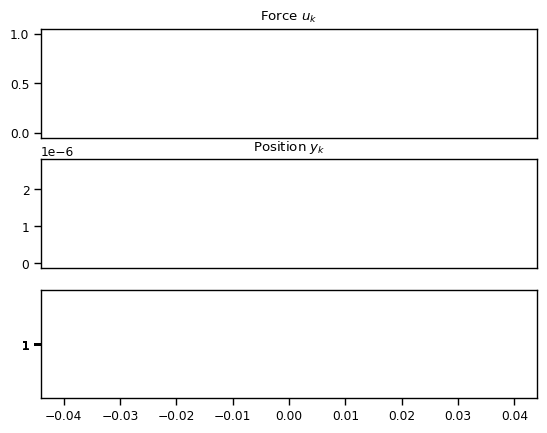

In [340]:
ssm = example_mass(k=40, b=5, m=1)

# L samples of u(t).
L = 100
step = 1.0 / L
ks = np.arange(L)
u = example_force(ks * step)
print(u)
# Approximation of y(t).
y = SSM_S4(torch.rand((1)),u[:,np.newaxis], *ssm).reshape(-1).numpy()
# Plotting ---
import matplotlib.pyplot as plt
import seaborn
from celluloid import Camera

seaborn.set_context("paper")
fig, (ax1, ax2, ax3) = plt.subplots(3)
camera = Camera(fig)
ax1.set_title("Force $u_k$")
ax2.set_title("Position $y_k$")
#ax3.set_title("Object")
ax1.set_xticks([], [])
ax2.set_xticks([], [])

# Animate plot over time
for k in range(0, L, 2):
    print([y[k] - 0.04, y[k], y[k] + 0.04])
    ax1.plot(ks[:k], u[:k], color="red")
    ax2.plot(ks[:k], y[:k], color="blue")
    ax3.boxplot(
        [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
        showcaps=False,
        whis=False,
        vert=False,
        widths=10,
    )
    camera.snap()
anim = camera.animate()
anim.save("line.gif", dpi=150, writer="imagemagick")

In [ ]:
def example_ssm():
    # SSM
    ssm = example_mass(k=40, b=5, m=1)

    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(*ssm, u)
    print
    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("line.gif", dpi=150, writer="imagemagick")
if False:
    example_ssm()

In [31]:
example_ssm()

NameError: name 'example_ssm' is not defined